# Install pycaret, conda, rdkit

In [1]:
! pip install pycaret
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.8.2-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.8.2-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.8.2-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')
! conda install -c rdkit rdkit -y

     |████████████████████████████████| 288 kB 5.1 MB/s 
     |████████████████████████████████| 86 kB 4.3 MB/s 
     |████████████████████████████████| 261 kB 47.0 MB/s 
     |████████████████████████████████| 167 kB 68.1 MB/s 
     |████████████████████████████████| 1.7 MB 46.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 56 kB 4.4 MB/s 
     |████████████████████████████████| 6.8 MB 51.4 MB/s 
     |████████████████████████████████| 1.3 MB 28.7 MB/s 
     |████████████████████████████████| 15.5 MB 45.2 MB/s 
     |████████████████████████████████| 113 kB 63.6 MB/s 
     |████████████████████████████████| 2.0 MB 35.6 MB/s 
     |████████████████████████████████| 675 kB 73.0 MB/s 
     |████████████████████████████████| 62 kB 739 kB/s 
     |████████████████████████████████| 303 kB 59.5 MB/s 
     |███████████████████

# Install packages and modules


In [2]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from sklearn.model_selection import train_test_split
from pycaret.regression import *
from rdkit.Chem import DataStructs

# read and process data

In [4]:
file = pd.read_csv('molnet_bace.csv')
dataset = file[['mol', 'pIC50']]
train_data_x, test_data_x, train_y, test_y = train_test_split(dataset['mol'], dataset['pIC50'], test_size = 0.2, random_state = 1 )


In [5]:
def mol2fp(mol, radi=4, nBits=2048):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radi, nBits=nBits)
    arr = np.zeros((0,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr


In [6]:
nBits=2048
columns = [f'fp_{idx}' for idx in range(nBits)] + ['target']

train_mols = [Chem.MolFromSmiles(smi) for smi in train_data_x]
train_x = np.array([mol2fp(mol, nBits=nBits) for mol in train_mols])
train_target = np.array(train_y).reshape(-1,1)
train_data = np.concatenate([train_x, train_target], axis=1)
train_df = pd.DataFrame(train_data, columns=columns)

test_mols = [Chem.MolFromSmiles(smi) for smi in test_data_x]
test_x = np.array([mol2fp(mol, nBits=nBits) for mol in test_mols])
test_target = np.array(test_y).reshape(-1,1)
test_data = np.concatenate([test_x, test_target], axis=1)
test_df = pd.DataFrame(test_data, columns=columns)

# select best models

In [9]:
reg_models = setup(data=train_df, target='target', session_id=123)
best_models = compare_models(fold=5, n_select = 18, round = 2, sort = 'R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.58,0.62,0.79,0.65,0.11,0.10,3.27
par,Passive Aggressive Regressor,0.61,0.66,0.81,0.63,0.12,0.10,0.32
huber,Huber Regressor,0.61,0.68,0.82,0.62,0.12,0.10,2.06
rf,Random Forest Regressor,0.63,0.72,0.85,0.59,0.12,0.11,8.18
lightgbm,Light Gradient Boosting Machine,0.62,0.72,0.85,0.59,0.12,0.10,0.34
ridge,Ridge Regression,0.63,0.72,0.85,0.59,0.12,0.11,0.10
gbr,Gradient Boosting Regressor,0.68,0.79,0.89,0.55,0.13,0.12,2.05
knn,K Neighbors Regressor,0.66,0.86,0.92,0.51,0.13,0.11,0.52
ada,AdaBoost Regressor,0.82,1.02,1.01,0.42,0.15,0.14,2.00
et,Extra Trees Regressor,0.77,1.23,1.10,0.31,0.16,0.13,11.82


In [10]:
compare_models_results = get_config('display_container')[-1]
compare_models_results_sub = compare_models_results.iloc[:, [0, 1, 2, 3, 4, 6]]
compare_models_results_sub


,Model,MAE,MSE,RMSE,R2,MAPE
br,Bayesian Ridge,0.58,0.62,0.79,0.65,0.10
par,Passive Aggressive Regressor,0.61,0.66,0.81,0.63,0.10
huber,Huber Regressor,0.61,0.68,0.82,0.62,0.10
rf,Random Forest Regressor,0.63,0.72,0.85,0.59,0.11
lightgbm,Light Gradient Boosting Machine,0.62,0.72,0.85,0.59,0.10
ridge,Ridge Regression,0.63,0.72,0.85,0.59,0.11
gbr,Gradient Boosting Regressor,0.68,0.79,0.89,0.55,0.12
knn,K Neighbors Regressor,0.66,0.86,0.92,0.51,0.11
ada,AdaBoost Regressor,0.82,1.02,1.01,0.42,0.14
et,Extra Trees Regressor,0.77,1.23,1.10,0.31,0.13


In [14]:
best_models

[BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
               compute_score=False, copy_X=True, fit_intercept=True,
               lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
               normalize=False, tol=0.001, verbose=False),
 PassiveAggressiveRegressor(C=1.0, average=False, early_stopping=False,
                            epsilon=0.1, fit_intercept=True,
                            loss='epsilon_insensitive', max_iter=1000,
                            n_iter_no_change=5, random_state=123, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False),
 HuberRegressor(alpha=0.0001, epsilon=1.35, fit_intercept=True, max_iter=100,
                tol=1e-05, warm_start=False),
 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impuri

# train the best models: the 1st model

In [15]:
# helper function to get a nice model name
def get_model_name(e) :
    mn = str(e).split("(")[0]

    if 'catboost' in str(e):
        mn = 'CatBoostClassifier'
    
    model_dict_logging = {'BayesianRidge' : 'br',
                        'PassiveAggressiveRegressor' : 'par', 
                        'HuberRegressor' : 'huber',
                        'RandomForestRegressor' : 'rf',
                        'LGBMRegressor' : 'lightgbm',
                        'Ridge' : 'ridge', 
                        'GradientBoostingRegressor' : 'gbr', 
                        'KNeighborsRegressor' : 'knn',
                        'AdaBoostRegressor' : 'ada',
                        'ExtraTreesRegressor' : 'et',
                        'DecisionTreeRegressor' : 'dt',
                        'OrthogonalMatchingPursuit' : 'omp',
                        'Lasso' : 'lasso',
                        'ElasticNet' : 'en',
                        'LassoLars' : 'llar',
                        'DummyRegressor' : 'dummy',
                        'Lars' : 'lar',
                        'LinearRegression' : 'lr'} 

    return model_dict_logging.get(mn)


In [16]:
best_model_name_1 = get_model_name(best_models[0])
best_model_1 = create_model(best_model_name_1, round = 2)
best_model_1_cv_results = get_config('display_container')[-1]
best_model_1_cv_results_sub = best_model_1_cv_results.iloc[:, [0, 1, 2, 3, 5]]
best_model_1_cv_results_sub

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.61,0.63,0.79,0.66,0.12,0.11
1,0.56,0.63,0.80,0.58,0.11,0.09
2,0.50,0.46,0.68,0.76,0.10,0.09
3,0.53,0.48,0.69,0.75,0.10,0.09
4,0.50,0.42,0.65,0.78,0.09,0.08
5,0.63,0.75,0.86,0.59,0.12,0.10
6,0.60,0.63,0.79,0.66,0.11,0.10
7,0.58,0.57,0.76,0.69,0.11,0.10
8,0.50,0.49,0.70,0.59,0.10,0.08
9,0.63,0.68,0.83,0.64,0.11,0.10


,MAE,MSE,RMSE,R2,MAPE
0,0.61,0.63,0.79,0.66,0.11
1,0.56,0.63,0.80,0.58,0.09
2,0.50,0.46,0.68,0.76,0.09
3,0.53,0.48,0.69,0.75,0.09
4,0.50,0.42,0.65,0.78,0.08
5,0.63,0.75,0.86,0.59,0.10
6,0.60,0.63,0.79,0.66,0.10
7,0.58,0.57,0.76,0.69,0.10
8,0.50,0.49,0.70,0.59,0.08
9,0.63,0.68,0.83,0.64,0.10


In [17]:
tuned_model_1 = tune_model(best_model_1, round = 2)
tuned_model_1_cv_results = get_config('display_container')[-1]
tuned_model_1_cv_results_sub = tuned_model_1_cv_results.iloc[:, [0, 1, 2, 3, 5]]
tuned_model_1_cv_results_sub

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.61,0.63,0.79,0.66,0.12,0.11
1,0.56,0.63,0.80,0.58,0.11,0.09
2,0.50,0.46,0.68,0.76,0.10,0.09
3,0.53,0.48,0.69,0.75,0.10,0.09
4,0.50,0.42,0.65,0.78,0.09,0.08
5,0.63,0.75,0.86,0.59,0.12,0.10
6,0.60,0.63,0.79,0.66,0.11,0.10
7,0.58,0.57,0.76,0.69,0.11,0.10
8,0.50,0.49,0.70,0.59,0.10,0.08
9,0.63,0.68,0.83,0.64,0.11,0.10


,MAE,MSE,RMSE,R2,MAPE
0,0.61,0.63,0.79,0.66,0.11
1,0.56,0.63,0.80,0.58,0.09
2,0.50,0.46,0.68,0.76,0.09
3,0.53,0.48,0.69,0.75,0.09
4,0.50,0.42,0.65,0.78,0.08
5,0.63,0.75,0.86,0.59,0.10
6,0.60,0.63,0.79,0.66,0.10
7,0.58,0.57,0.76,0.69,0.10
8,0.50,0.49,0.70,0.59,0.08
9,0.63,0.68,0.83,0.64,0.10


In [19]:
tuned_model_1_cv_mean_results = tuned_model_1_cv_results_sub.loc['Mean',:]
tuned_model_1_cv_mean_results.name = 'test_cv'
tuned_model_1_cv_mean_results

MAE     0.56
MSE     0.57
RMSE    0.75
R2      0.67
MAPE    0.09
Name: test_cv, dtype: float64

# Residual Plot

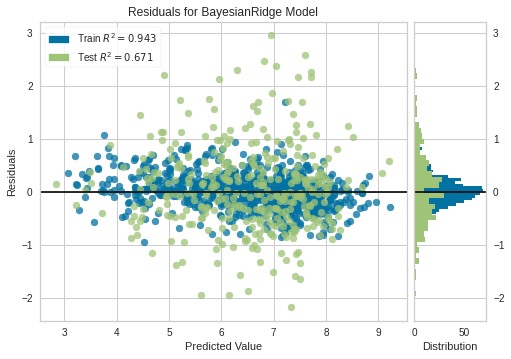

In [21]:
plot_model(tuned_model_1)

# Prediction Error Plot

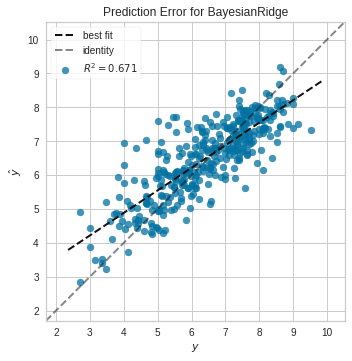

In [22]:
plot_model(tuned_model_1, plot = 'error')

# Feature Importance Plot

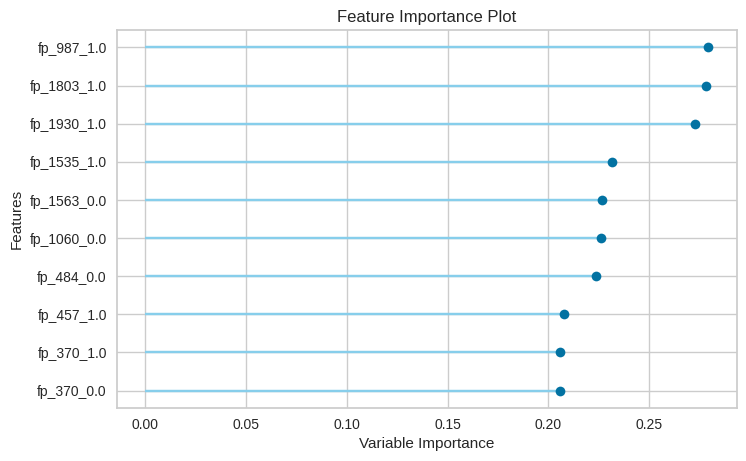

In [23]:
plot_model(tuned_model_1, plot='feature')

# evaluate model

In [24]:
evaluate_model(tuned_model_1)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [25]:
predict_model_result = predict_model(tuned_model_1, round=2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.6,0.64,0.8,0.67,0.12,0.1


In [27]:
final_model_1 = finalize_model(tuned_model_1)
final_model_1

BayesianRidge(alpha_1=0.001, alpha_2=0.01, alpha_init=None, compute_score=True,
              copy_X=True, fit_intercept=True, lambda_1=0.0005, lambda_2=1e-06,
              lambda_init=None, n_iter=300, normalize=False, tol=0.001,
              verbose=False)

In [28]:
predict_model(final_model_1, round=2)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.32,0.18,0.42,0.91,0.06,0.06


,fp_1473,fp_1874,fp_0_0.0,fp_1_0.0,fp_2_0.0,fp_3_1.0,fp_4_0.0,fp_5_0.0,fp_6_1.0,fp_7_1.0,fp_8_1.0,fp_9_0.0,fp_10_1.0,fp_11_1.0,fp_12_0.0,fp_13_1.0,fp_14_1.0,fp_15_1.0,fp_17_0.0,fp_18_1.0,fp_19_1.0,fp_20_0.0,fp_21_0.0,fp_22_1.0,fp_23_0.0,fp_24_1.0,fp_25_0.0,fp_26_1.0,fp_27_0.0,fp_27_1.0,fp_28_0.0,fp_29_1.0,fp_30_1.0,fp_31_1.0,fp_32_0.0,fp_33_1.0,fp_34_0.0,fp_34_1.0,fp_35_1.0,fp_36_0.0,...,fp_2008_0.0,fp_2009_0.0,fp_2010_0.0,fp_2011_0.0,fp_2012_1.0,fp_2013_1.0,fp_2014_1.0,fp_2015_1.0,fp_2016_1.0,fp_2018_0.0,fp_2019_0.0,fp_2020_0.0,fp_2021_0.0,fp_2022_0.0,fp_2023_1.0,fp_2024_0.0,fp_2025_1.0,fp_2026_1.0,fp_2027_1.0,fp_2028_1.0,fp_2029_1.0,fp_2031_1.0,fp_2032_1.0,fp_2033_1.0,fp_2034_0.0,fp_2035_1.0,fp_2036_1.0,fp_2037_1.0,fp_2038_0.0,fp_2039_1.0,fp_2040_0.0,fp_2041_1.0,fp_2042_1.0,fp_2043_1.0,fp_2044_1.0,fp_2045_1.0,fp_2046_1.0,fp_2047_1.0,target,Label
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.537602,5.855564
1,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.187756,8.164710
2,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.091515,6.139568
3,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.508638,8.030260
4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.142667,6.075053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,6.537602,6.205376
360,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.568636,7.038251
361,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.000000,8.373308
362,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.

# predict unsee data

In [30]:
unseen_predictions = predict_model(final_model_1, data=test_df)
unseen_predictions.head()

,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,fp_7,fp_8,fp_9,fp_10,fp_11,fp_12,fp_13,fp_14,fp_15,fp_16,fp_17,fp_18,fp_19,fp_20,fp_21,fp_22,fp_23,fp_24,fp_25,fp_26,fp_27,fp_28,fp_29,fp_30,fp_31,fp_32,fp_33,fp_34,fp_35,fp_36,fp_37,fp_38,fp_39,...,fp_2010,fp_2011,fp_2012,fp_2013,fp_2014,fp_2015,fp_2016,fp_2017,fp_2018,fp_2019,fp_2020,fp_2021,fp_2022,fp_2023,fp_2024,fp_2025,fp_2026,fp_2027,fp_2028,fp_2029,fp_2030,fp_2031,fp_2032,fp_2033,fp_2034,fp_2035,fp_2036,fp_2037,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047,target,Label
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,7.508638,7.270127
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,6.346787,6.578083
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.244125,5.953680
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.552842,7.470657
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.801343,5.519724


In [34]:
from pycaret.utils import check_metric

mae = check_metric(unseen_predictions.target, unseen_predictions.Label, 'MAE')
mse = check_metric(unseen_predictions.target, unseen_predictions.Label, 'MSE')
rmse = check_metric(unseen_predictions.target, unseen_predictions.Label, 'RMSE')
r2 = check_metric(unseen_predictions.target, unseen_predictions.Label, 'R2')
mape = check_metric(unseen_predictions.target, unseen_predictions.Label, 'MAPE')

test_results_series = pd.Series([mae, mse, rmse, r2, mape], index=['MAE', 'MSE', 'RMSE', 'R2', 'MAPE'], name = 'test_ext').round(2)
test_results_series

MAE     0.57
MSE     0.56
RMSE    0.75
R2      0.67
MAPE    0.09
Name: test_ext, dtype: float64

In [35]:
final_eval_results = pd.concat([tuned_model_1_cv_mean_results, test_results_series], axis=1).T
final_eval_results

,MAE,MSE,RMSE,R2,MAPE
test_cv,0.56,0.57,0.75,0.67,0.09
test_ext,0.57,0.56,0.75,0.67,0.09
